# Australia Weather Forecasting
### By Fahmi Jabbar (rootmawar77@gmail.com)
---
**Disclaimer :** 
- Any code below is done by purposed to complete *Dicoding* Submission and made 100% by myself



---
**Dataset Information** : 

![Dataset Information](https://image.prntscr.com/image/XwiEbOFdR9uiuPiRvnLDsg.png)

Link : https://www.kaggle.com/jsphyg/weather-dataset-rattle-package

Consist 142k time series weather data between 1 Nov 2007 - 25 Jun 2017

## Import Important Libraries

In [1]:
import matplotlib.pyplot as plt
import os, sys, datetime
import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split

## Download & Unzip Dataset

In [2]:
os.environ['KAGGLE_USERNAME'] = "fahmijabbar"
os.environ['KAGGLE_KEY'] = "70e97bf263ab4ed3b437c10c73941268"

In [3]:
!kaggle datasets download -d jsphyg/weather-dataset-rattle-package

  0% 0.00/3.87M [00:00<?, ?B/s]
100% 3.87M/3.87M [00:00<00:00, 59.2MB/s]


In [4]:
!unzip /content/weather-dataset-rattle-package.zip

Archive:  /content/weather-dataset-rattle-package.zip
  inflating: weatherAUS.csv          


## EDA

### txt to pandas dataframe

In [5]:
df = pd.read_csv('/content/weatherAUS.csv')

In [6]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


### Check for empty value

In [7]:
df.isna().sum()

Date                 0
Location             0
MinTemp            637
MaxTemp            322
Rainfall          1406
Evaporation      60843
Sunshine         67816
WindGustDir       9330
WindGustSpeed     9270
WindDir9am       10013
WindDir3pm        3778
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
RainToday         1406
RISK_MM              0
RainTomorrow         0
dtype: int64

In [8]:
# Drop any null or empty data
df = df.dropna(how='any')

In [9]:
df.isna().sum()

Date             0
Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RISK_MM          0
RainTomorrow     0
dtype: int64

## Submission objective

**Please read this**

I would like to forecast the max temprature from time to time, regardless to any other condition

I will make this dataset as univariate dataset

### Removing Unnecessary columns

In [10]:
removecol = []
for columns in df.columns:
  if (columns == 'Date' or columns == 'MaxTemp'):
    pass
  else:
    removecol.append(columns)

In [11]:
df.drop(removecol, axis=1, inplace=True)

### Sort by date time

In [12]:
df = df.sort_values('Date')

In [13]:
df.head()

,Date,MaxTemp
44351,2007-11-01,24.3
44352,2007-11-02,26.9
44353,2007-11-03,23.4
44354,2007-11-04,15.5
44355,2007-11-05,16.1


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56420 entries, 44351 to 78750
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     56420 non-null  object 
 1   MaxTemp  56420 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.3+ MB


### Temprature Visualization from time to time

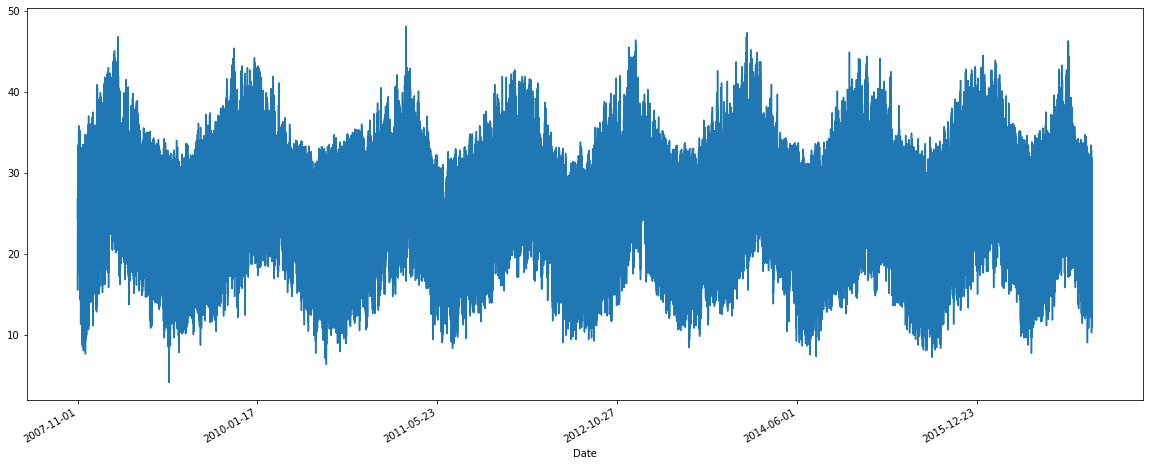

In [15]:
plot_features = df['MaxTemp']
plot_features.index = df['Date']
_ = plot_features.plot(figsize=(20,8), subplots=True)

As you can see, it's seasonal dataset

if the max temp is low that means winter, otherwise summer. 

Anything in between is autumn or spring.

### Requirements

Find minimum data and maximum data

In [16]:
minscale = df['MaxTemp'].min()
print(minscale)
maxscale = df['MaxTemp'].max()
print(maxscale)

4.1
48.1


My minimum MAE is

In [17]:
maeRequirements = (maxscale - minscale) * 10/100
maeRequirements

4.4

## Data Preparation

In [18]:
#Important function, sources : https://github.com/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%204%20Exercise%20Answer.ipynb
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

### Split Dataset

In [19]:
split_time = int(len(df) * 0.8)
window_size = 64
batch_size = 256
shuffle_buffer_size = 1000

In [20]:
date_train = df['Date'].values[:split_time]
x_train = df['MaxTemp'].values[:split_time]
date_val = df['Date'].values[split_time:]
x_val = df['MaxTemp'].values[split_time:]

In [21]:
print(len(x_train))
print(len(x_val))
print(len(date_train))
print(len(date_val))

45136
11284
45136
11284


The dataset reduced to around 56k due to lots of null rows and I remove it

### Change dataset to windowed dataset

In [22]:
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

## Model Creation

### Model Architecture

In [23]:
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(16, activation="relu"),
  tf.keras.layers.Dense(8, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

### Callback Function

In [24]:
#Learning Rate Scheduler
lrs_callback = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(2))

#Tensorboard
!rm -rf /content/logs
log_dir="/content/logs/"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

#Custom callback
class stopTraining(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae') is not None and logs.get('mae') <= maeRequirements):
      print("\n\nReached", maeRequirements, "MAE, i think it's enough\n")
      self.model.stop_training = True

custom_callback = stopTraining()

### Model Training

In [25]:
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [26]:
model.fit(train_set, epochs=100, callbacks=[lrs_callback, tensorboard_callback, custom_callback], batch_size=512)

Epoch 1/100
      1/Unknown - 0s 54us/step - loss: 37.4883 - mae: 37.9870WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
      2/Unknown - 1s 271ms/step - loss: 37.6791 - mae: 38.1779WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1773s vs `on_train_batch_end` time: 0.3644s). Check your callbacks.
177/177 [==============================] - 31s 177ms/step - loss: 8.3167 - mae: 8.8035
Epoch 2/100
177/177 [==============================] - 32s 183ms/step - loss: 6.1464 - mae: 6.6297
Epoch 3/100
177/177 [==============================] - 32s 181ms/step - loss: 5.4182 - mae: 5.8997
Epoch 4/100
177/177 [==============================] - 31s 175ms/step - loss: 4.9972 - mae: 5.4776
Epoch 5/100
177/177 [=======

## Visualizing model using tensorboard


In [27]:
!tensorboard dev upload --logdir /content/logs \
  --name "Australian Weather Forecasting Model" \
  --description "Dicoding Submission 2 - Time Series. Model made by Fahmi Jabbar" \
  --one_shot

2020-08-13 06:32:02.914319: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

/content/logs

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) y

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Ao

Please visit : https://tensorboard.dev/experiment/buPrwt4GSpq9FVQLQ9Wwjg/

Some screenshoots in case the web is expired

**Loss Results**

![Loss Graph](https://image.prntscr.com/image/bawy5NgrTOmMp1G5K4bYUw.png)

**MAE Results**

![MAE Graph](https://image.prntscr.com/image/rbsPRdzxRI_5xk5UYEaDtw.png)




## Forecasting

In [29]:
#source : https://github.com/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%204%20Exercise%20Answer.ipynb
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.xticks([])
    plt.grid(True)

In [30]:
series = np.array(df['MaxTemp'])
forecast = model_forecast(model, series[..., np.newaxis], window_size)
forecast = forecast[split_time - window_size:-1, -1, 0]

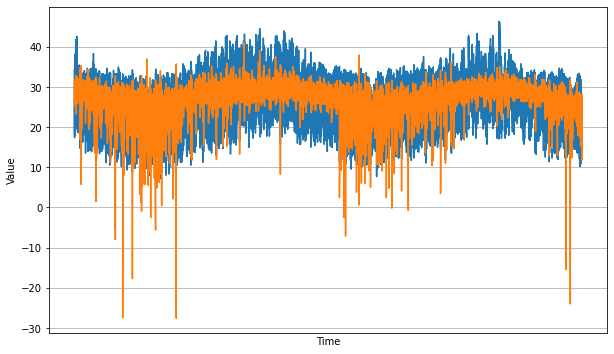

In [36]:
plt.figure(figsize=(10, 6))
plot_series(date_val, x_val)
plot_series(date_val, forecast)

As you can see, the model did quite well knowing the seasonal time/pattern, but the actual prediction is not 100% accurate due to high losses, but my MAE is below 10% data scale as explained in the code or results.